Now, I will create the graphs using the features calculated. 3 graphs will be created:
1. Geographical distance graph
2. Functional similarity graph
3. Travel impedance graph

In [1]:
import pandas as pd
import os
import numpy as np
import networkx as nx
from tqdm import tqdm
from datetime import datetime
import geopandas as gpd
from scipy.spatial.distance import cdist
import pickle
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
# loading the adjacency matrices
# loading the adjacency matrices
adj_df_before_june21 = pd.read_csv('data/graph/adj_mat_before_june21.csv', index_col = 0)
adj_df = pd.read_csv('data/graph/cta_adj_mat_final.csv', index_col = 0)
adj_df_from_june21 = pd.read_csv('data/graph/adj_mat_june21.csv', index_col = 0)
adj_df_from_aug23 = pd.read_csv('data/graph/adj_mat_aug23.csv', index_col = 0)
adj_df_from_aug24 = pd.read_csv('data/graph/adj_mat_aug24.csv', index_col = 0)

In [84]:
# loading the coordinates for each station
# loading the shapefile for stations
stations = gpd.read_file("data/l_stations/CTA_RailStations.shp")
print(stations.shape)
stations.head()

(144, 9)


,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (1118914.131 1937256.046)
1,1350,Oak Park-Lake,Green Line (Lake),100 S. Oak Park Avenue,0,0,1.131166e+06,1.901870e+06,POINT (1131166.01 1901870.067)
2,1260,Austin-Lake,Green Line (Lake),351 N. Austin Blvd,0,0,1.136515e+06,1.902016e+06,POINT (1136515.354 1902015.556)
3,170,Ashland-Lake,"Green (Lake), Pink",1601 W. Lake Street,1,0,1.165707e+06,1.901502e+06,POINT (1165706.564 1901501.957)
4,1160,Clinton-Lake,"Green (Lake), Pink",540 W. Lake Street,1,0,1.172562e+06,1.901699e+06,POINT (1172561.887 1901699.061)


In [85]:
# getting coordinates for damen-lake
from shapely.geometry import Point

lat, lon = 41.88499118845606, -87.67689573558924

# Create a GeoSeries in WGS84
g = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326")

# Convert to EPSG:26916
g_utm = g.to_crs("EPSG:26916")

print(g_utm.iloc[0].x, g_utm.iloc[0].y)

443840.1312841872 4637228.542699575


In [86]:
print(stations.crs)
stations = stations.to_crs(epsg=26916)
print(stations.crs)

EPSG:3435
EPSG:26916


In [87]:
# setting the position for each node
# used adj_df because it has all the stations to date
pos = {node:(stations[stations['LONGNAME']==node].geometry.x, stations[stations['LONGNAME']==node].geometry.y) for node in adj_df.columns if node!='Damen-Lake'}
pos2 = {k:(v[0].iloc[0], v[1].iloc[0]) for k,v in pos.items()}
# adding damen-lake coordinates
pos2['Damen-Lake'] = (np.float64(443840.1312841872), np.float64(4637228.542699575))

# Creating the graphs
## NOTE: IGNORE THIS SECTION, JUMP TO THE NEXT SECTION, THIS SECTION CREATES THE GRAPHS FOR GRAPH ATTENTION, BUT GRAPH ATTENTION IS NOT BEING USED IN THIS PROJECT AT THIS POINTN OF TIME.

## 1. Geographical distance graph
For the geographical distance, I am going to use straightline distance between two stations.

### 1.1. For from June 2021

In [98]:
# getting the coordinates in order of the stations in the adjacency matrix
coords_in_order = np.array([pos2[n] for n in adj_df_from_june21.columns])
coords_in_order.shape

(141, 2)

In [99]:
distances = cdist(coords_in_order, coords_in_order, 'euclidean')
distances.shape

(141, 141)

In [100]:
# calculating the standard deviation
dist_std = np.std(distances)
dist_std

np.float64(6730.572748521612)

In [101]:
mat = np.exp(-distances/dist_std)
mat.shape

(141, 141)

In [102]:
distances_df_from_june21 = pd.DataFrame(mat, columns=adj_df_from_june21.columns, index=adj_df_from_june21.index)
distances_df_from_june21.shape

(141, 141)

In [103]:
distances_df_from_june21

,Cumberland,Oak Park-Lake,Austin-Lake,Ashland-Lake,Clinton-Lake,Grand/Milwaukee,Chicago/Milwaukee,Damen/Milwaukee,California/Milwaukee,Belmont-O'Hare,...,Washington/Wells,Southport,Adams/Wabash,Jackson/State,Rosemont,Harlem-Lake,Division/Milwaukee,95th/Dan Ryan,63rd-Dan Ryan,Garfield-Dan Ryan
Cumberland,1.000000,0.183554,0.168087,0.069538,0.054279,0.060574,0.068493,0.097399,0.132709,0.178252,...,0.048688,0.105516,0.043673,0.043799,0.768548,0.189401,0.082153,0.006342,0.014692,0.017843
Oak Park-Lake,0.183554,1.000000,0.784856,0.209354,0.153510,0.164715,0.180038,0.227120,0.265536,0.269574,...,0.139069,0.156017,0.126079,0.128233,0.167695,0.890647,0.203531,0.032486,0.069406,0.081177
Austin-Lake,0.168087,0.784856,1.000000,0.266688,0.195564,0.209856,0.229243,0.287075,0.329445,0.322190,...,0.177114,0.191966,0.160500,0.163199,0.149093,0.699030,0.258491,0.037299,0.082581,0.097748
Ashland-Lake,0.069538,0.209354,0.266688,1.000000,0.733109,0.772800,0.795298,0.654907,0.492641,0.355036,...,0.663462,0.380625,0.598914,0.606939,0.056638,0.186474,0.742516,0.064660,0.167892,0.212842
Clinton-Lake,0.054279,0.153510,0.195564,0.733109,1.000000,0.891024,0.788059,0.553204,0.404610,0.293285,...,0.896284,0.369485,0.803671,0.806866,0.043775,0.136730,0.656063,0.067019,0.175524,0.224226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Harlem-Lake,0.189401,0.890647,0.699030,0.186474,0.136730,0.146706,0.160392,0.202892,0.238818,0.245893,...,0.123881,0.140903,0.112329,0.114261,0.175797,1.000000,0.181499,0.030285,0.063634,0.074030
Division/Milwaukee,0.082153,0.203531,0.258491,0.742516,0.656063,0.735181,0.832165,0.842714,0.616319,0.446979,...,0.590201,0.512552,0.530162,0.530132,0.065949,0.181499,1.000000,0.048301,0.125825,0.159917
95th/Dan Ryan,0.006342,0.032486,0.037299,0.064660,0.067019,0.060846,0.055549,0.042453,0.032996,0.024212,...,0.070848,0.025104,0.074855,0.076534,0.005562,0.030285,0.048301,1.000000,0.381813,0.298856
63rd-Dan Ryan,0.014692,0.069406,0.082581,0.167892,0.175524,0.159324,0.145255,0.110019,0.084570,0.061625,...,0.185326,0.065655,0.195176,0.199710,0.012591,0.063634,0.125825,0.381813,1.000000,0.782285


In [104]:
# saving
distances_df_from_june21.to_csv('data/graph/geographical_distance/from_june21.csv')

#### 1.2. For before June 2021

In [83]:
# getting the coordinates in order of the stations in the adjacency matrix
coords_in_order = np.array([pos2[n] for n in adj_df_before_june21.columns])
coords_in_order.shape

(143, 2)

In [84]:
distances = cdist(coords_in_order, coords_in_order, 'euclidean')
distances.shape

(143, 143)

In [85]:
# calculating the standard deviation
dist_std = np.std(distances)
dist_std

np.float64(6707.5223292920555)

In [86]:
mat = np.exp(-distances/dist_std)
mat.shape

(143, 143)

In [87]:
distances_df_before_june21 = pd.DataFrame(mat, columns=adj_df_before_june21.columns, index=adj_df_before_june21.index)
distances_df_before_june21.shape

(143, 143)

In [88]:
# saving
distances_df_before_june21.to_csv('data/graph/geographical_distance/before_june21.csv')

#### 1.3. For from Aug 23

In [90]:
# getting the coordinates in order of the stations in the adjacency matrix
coords_in_order = np.array([pos2[n] for n in adj_df_from_aug23.columns])
coords_in_order.shape

(140, 2)

In [91]:
distances = cdist(coords_in_order, coords_in_order, 'euclidean')
distances.shape

(140, 140)

In [92]:
# calculating the standard deviation
dist_std = np.std(distances)
dist_std

np.float64(6737.535701363157)

In [93]:
mat = np.exp(-distances/dist_std)
mat.shape

(140, 140)

In [94]:
distances_df_from_aug23 = pd.DataFrame(mat, columns=adj_df_from_aug23.columns, index=adj_df_from_aug23.index)
distances_df_from_aug23.shape

(140, 140)

In [95]:
# saving
distances_df_from_aug23.to_csv('data/graph/geographical_distance/from_aug23.csv')

#### 1.4. For from Aug 24

In [105]:
# getting the coordinates in order of the stations in the adjacency matrix
coords_in_order = np.array([pos2[n] for n in adj_df_from_aug24.columns])
coords_in_order.shape

(142, 2)

In [106]:
distances = cdist(coords_in_order, coords_in_order, 'euclidean')
distances.shape

(142, 142)

In [92]:
# calculating the standard deviation
dist_std = np.std(distances)
dist_std

np.float64(6737.535701363157)

In [93]:
mat = np.exp(-distances/dist_std)
mat.shape

(140, 140)

In [109]:
distances_df_from_aug24 = pd.DataFrame(mat, columns=adj_df_from_aug24.columns, index=adj_df_from_aug24.index)
distances_df_from_aug24.shape

(142, 142)

In [110]:
# saving
distances_df_from_aug24.to_csv('data/graph/geographical_distance/from_aug24.csv')

#### 1.5. For from june 25

In [111]:
# getting the coordinates in order of the stations in the adjacency matrix
coords_in_order = np.array([pos2[n] for n in adj_df.columns])
coords_in_order.shape

(144, 2)

In [112]:
distances = cdist(coords_in_order, coords_in_order, 'euclidean')
distances.shape

(144, 144)

In [113]:
# calculating the standard deviation
dist_std = np.std(distances)
dist_std

np.float64(6696.675337775666)

In [114]:
mat = np.exp(-distances/dist_std)
mat.shape

(144, 144)

In [115]:
distances_df_from_june25 = pd.DataFrame(mat, columns=adj_df.columns, index=adj_df.index)
distances_df_from_june25.shape

(144, 144)

In [116]:
# saving
distances_df_from_june25.to_csv('data/graph/geographical_distance/from_june25.csv')

## 2. Functional similarity graph

This is just RBF kernel similarity between two nodes.

In [119]:
# loading the built environment features data
with open('data/graph/built_env/features.pkl', 'rb') as f:
    built_env_features = pickle.load(f)

In [125]:
# concatenating the lists for each node
x_b_dict = {}
for k, v in built_env_features.items():
    x_b_dict[k] = np.concat(v)

In [162]:
def get_functional_similarity_df(adj, xb_dict = x_b_dict):
    # get all the features in order
    features_in_order = np.vstack([x_b_dict[k] for k in adj.columns])
    # scaling features
    scaled = (features_in_order - np.min(features_in_order, axis=0, keepdims=True))/(np.max(features_in_order, axis=0, keepdims=True) - np.min(features_in_order, axis=0, keepdims=True))
    # calculating similarities
    similarities = rbf_kernel(scaled, scaled)
    sim_df = pd.DataFrame(similarities, index=adj.index, columns=adj.columns)
    return sim_df

#### 2.1. For From June 2021

In [164]:
sim_df = get_functional_similarity_df(adj_df_from_june21)
sim_df.shape

(141, 141)

In [166]:
# saving
sim_df.to_csv('data/graph/functional_sim/from_june21.csv')

#### 2.2. For before June 2021

In [167]:
sim_df = get_functional_similarity_df(adj_df_before_june21)
sim_df.shape

(143, 143)

In [168]:
# saving
sim_df.to_csv('data/graph/functional_sim/before_june21.csv')

#### 2.3. For From Aug 23

In [175]:
sim_df = get_functional_similarity_df(adj_df_from_aug23)
sim_df.shape

(140, 140)

In [176]:
# saving
sim_df.to_csv('data/graph/functional_sim/from_aug23.csv')

#### 2.4. For From Aug24

In [177]:
sim_df = get_functional_similarity_df(adj_df_from_aug24)
sim_df.shape

(142, 142)

In [178]:
# saving
sim_df.to_csv('data/graph/functional_sim/from_aug24.csv')

#### 2.5. For from June 25

In [181]:
sim_df = get_functional_similarity_df(adj_df)
sim_df.shape

(144, 144)

In [182]:
# saving
sim_df.to_csv('data/graph/functional_sim/from_june25.csv')

## 3. Travel impedance graph.
I am not calculating the travel impedance graph

# Creating the training dataset.

In [3]:
# loading the counts
ridership_data = pd.read_csv('data/l_ridership_filtered.csv')
ridership_data['station_id'] = ridership_data['station_id'].astype(int)
print(ridership_data.shape)
ridership_data.head()

(9784, 7)


,station_id,stationame,month_beginning,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,monthtotal
0,40900,Howard,2020-01-01,"4,801.2","2,852","2,304.4",128557.0
1,41190,Jarvis,2020-01-01,"1,359.3","1,027.5",811.4,38071.0
2,40100,Morse,2020-01-01,"4,119.4","2,628","2,091.8",111598.0
3,41300,Loyola,2020-01-01,"4,869.3","3,517","2,590",134143.0
4,40760,Granville,2020-01-01,"3,533.1","1,619.8","1,392.4",91169.0


I need to rename the station names to make sure that they are the same names. I will be renaming stations in the ridership dataframe.

In [4]:
ages_data = pd.read_csv('data/l_station_ages.csv')[['station_id', 'stationame', 'age']]
ages_data = ages_data.iloc[:149]
ages_data['station_id'] = ages_data['station_id'].astype(int)
print(ages_data.shape)
ages_data.head()

(149, 3)


,station_id,stationame,age
0,40900,Howard,1410.0
1,41190,Jarvis,1410.0
2,40100,Morse,1410.0
3,41300,Loyola,1410.0
4,40760,Granville,1410.0


In [5]:
# drop rows where the age is none from ages data
ages_data = ages_data[~ages_data['age'].isna()]
ages_data.shape

(147, 3)

In [6]:
# joining the two tables, to get the station age, as well as the consistent names
joined_data = pd.merge(ridership_data, ages_data, on='station_id', how='inner', suffixes=['_rider', '_age'])
joined_data.shape

(9784, 9)

In [7]:
joined_data.isna().sum()

station_id                  0
stationame_rider            0
month_beginning             0
avg_weekday_rides           0
avg_saturday_rides          0
avg_sunday-holiday_rides    0
monthtotal                  0
stationame_age              0
age                         0
dtype: int64

In [8]:
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [9]:
# loading the structure features
sfeats_before_june21 = load_pickle('data/graph/spatial/spatial_before_june21.pkl')
sfeats_from_june21 = load_pickle('data/graph/spatial/spatial_jun21.pkl')
sfeats_from_aug23 = load_pickle('data/graph/spatial/spatial_aug23.pkl')
sfeats_from_aug24 = load_pickle('data/graph/spatial/spatial_aug24.pkl')
sfeats_from_sep23 = load_pickle('data/graph/spatial/spatial_sep23.pkl')
sfeats_from_june25 = load_pickle('data/graph/spatial/spatial_june25.pkl')

In [10]:
feat_dict_list = [sfeats_before_june21, sfeats_from_june21, sfeats_from_aug23, sfeats_from_sep23, sfeats_from_aug24, sfeats_from_june25]

## Creating the dataset

The dataset will be a concatenation of:
1. The multimodal transport features: # bus lines, # bus stops
2. The built population features: house value vector, population value vector
3. The temporal features: age of station, month of the year vector

Additionally, it will also contain the graph attention features that will be concatenated to these.

In [11]:
# loading all these
# multimodal
with open('data/graph/micromodal/features.pkl', 'rb') as f:
    multimodal_features = pickle.load(f)

In [12]:
# built features
with open('data/graph/built_env/features.pkl', 'rb') as f:
    built_env_features = pickle.load(f)
# concatenating the 2 lists in a single array
built_env_final = {}
for k, v in built_env_features.items():
    built_env_final[k] = np.concat([v[0][:-1], v[1][:-1]])

Temporal features will be calculated on the fly while looping through the joined_data dataframe.

In [13]:
joined_data['month_beginning'] = joined_data['month_beginning'].map(lambda d: datetime.strptime(d, r'%Y-%m-%d').date())
joined_data.shape

(9784, 9)

In [14]:
feat_dict_list = [sfeats_before_june21, sfeats_from_june21, sfeats_from_aug23, sfeats_from_sep23, sfeats_from_aug24, sfeats_from_june25]

In [15]:
def get_correct_dict(year, month, dict_list = feat_dict_list):
    if year==2020: #
        # print("return 0")
        return dict_list[0]
    elif year==2021:
        if month>=6:
#             print("return 1")
            return dict_list[1]
        else:
#             print('return 0')
            return dict_list[0]
    elif year==2022:
#         print('return 1')
        return dict_list[1]
    elif year==2023:
        if month==8:
#             print('return 2')
            return dict_list[2]
        elif month<9:
#             print('return 1')
            return dict_list[1]
        else:
#             print('return 3')
            return dict_list[3]
    elif year==2024:
        if month<8:
#             print('return 3')
            return dict_list[3]
        else:
#             print('return 4')
            return dict_list[4]
    elif year==2025:
        if month<7:
            return dict_list[4]
        else:
#             print('return 5')
            return dict_list[5]
    else:
        raise ValueError("Invalid month and/or year")

In [16]:
o = get_correct_dict(2021, 6)

In [17]:
joined_data['month_beginning'][724].month, joined_data['month_beginning'][724].year

(6, 2020)

In [18]:
built_env_final['Argyle']

array([1.17611111e+03, 3.34582938e-01, 3.65383333e+05, 2.78922007e-01])

In [19]:
final_data = []
y = []

for i, row in joined_data.iterrows():
    # temporal features
    # get the station age
    stn_age = row['age']
    month = row['month_beginning'].month
    year = row['month_beginning'].year
    sname = row['stationame_age']

    # get the multimodal transport data for the station
    mmodal_arr = multimodal_features[sname]
    # get the built features for the station
    built_arr = built_env_final[sname]
    # creating onehot encoded vector for month
    month_ohe = [0]*12
    month_ohe[month-1] = 1

    # getting the correct spatial feature dictionary
    corr_dict = get_correct_dict(year, month)
    # get station's structural features
    str_feats = corr_dict[sname]

    # adding all to a list
    feat_list = [sname,stn_age,month,year] + month_ohe + mmodal_arr+ built_arr.tolist() + str_feats
    final_data.append(feat_list)
    y.append(row['monthtotal'])

In [20]:
len(y), len(final_data)

(9784, 9784)

In [21]:
# creating a dataframe
colnames = ['stationame', 'age', 'month', 'year', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec', 'n_busstops', 'n_buslines', 'avg_pop', 'pop_error', 'avg_house_val', 'house_val_error', 'deg_cent', 'close_cent', 'eig_cent', 'katz_cent', 'deg', 'is_inter', 'is_term', 'stn_line_cnt']
final_data_df = pd.DataFrame(final_data, columns=colnames)
print(final_data_df.shape)
final_data_df.head()

(9784, 30)


,stationame,age,month,year,jan,feb,mar,apr,may,jun,...,avg_house_val,house_val_error,deg_cent,close_cent,eig_cent,katz_cent,deg,is_inter,is_term,stn_line_cnt
0,Howard,1410.0,1,2020,1,0,0,0,0,0,...,293200.000000,0.377184,0.028169,0.081844,0.002100,0.100697,4,1,1,3
1,Jarvis,1410.0,1,2020,1,0,0,0,0,0,...,325542.857143,0.363756,0.014085,0.076058,0.000747,0.083617,2,0,0,1
2,Morse,1410.0,1,2020,1,0,0,0,0,0,...,285512.500000,0.360355,0.014085,0.071036,0.000267,0.081891,2,0,0,1
3,Loyola,1410.0,1,2020,1,0,0,0,0,0,...,390525.000000,0.327073,0.014085,0.066635,0.000098,0.081717,2,0,0,1
4,Granville,1410.0,1,2020,1,0,0,0,0,0,...,270700.000000,0.303212,0.014085,0.062749,0.000043,0.081699,2,0,0,1


## Make the 2 graphs using the adjacency matrices calculated above
Here, we do not need to actually create the graphs, just the adjacency matrices will be enough.
#### 1. Geographical distance graphs

In [21]:
# loading the adjacency matrices
ag_from_june21 = pd.read_csv('data/graph/geographical_distance/from_june21.csv', index_col=0)
ag_before_june21 = pd.read_csv('data/graph/geographical_distance/before_june21.csv', index_col=0)
ag_from_aug23 = pd.read_csv('data/graph/geographical_distance/from_aug23.csv', index_col=0)
ag_from_aug24 = pd.read_csv('data/graph/geographical_distance/from_aug24.csv', index_col=0)
ag_from_june25 = pd.read_csv('data/graph/geographical_distance/from_june25.csv', index_col=0)

In [22]:
ag_from_june21.shape, ag_before_june21.shape, ag_from_aug23.shape, ag_from_aug24.shape, ag_from_june25.shape

((141, 141), (143, 143), (140, 140), (142, 142), (144, 144))

In [23]:
def make_geographical_graph(adj_df, k=10):
    '''
        This function creates a geographical graph, taking only the top 10 nodes wrt geographical distance for connections.
    '''
    # Work on a copy to avoid modifying the original DataFrame
    fixed_am_df = adj_df.copy()
    # Remove self-loops by zeroing diagonal
    np.fill_diagonal(fixed_am_df.values, 0)
    # Get the am array
    fixed_am = fixed_am_df.values
    # Compute k-th largest threshold per row
    thresh = np.partition(fixed_am, -k, axis=1)[:, -k]
    # Keep only top-k; zero others
    df_k = fixed_am_df.where(fixed_am_df.ge(thresh[:, None]), 0)

    return df_k

In [24]:
# creating the graphs
# there will be six graphs
G_g_from_june21 = make_geographical_graph(ag_from_june21)
G_g_before_june21 = make_geographical_graph(ag_before_june21)
G_g_from_aug23 = make_geographical_graph(ag_from_aug23)
G_g_from_sep23 = make_geographical_graph(ag_from_june21)
G_g_from_aug24 = make_geographical_graph(ag_from_aug24)
G_g_from_june25 = make_geographical_graph(ag_from_june25)

#### 2. Functional similarity graph

In [25]:
# loading the adjacency matrices
ab_from_june21 = pd.read_csv('data/graph/functional_sim/from_june21.csv', index_col=0)
ab_before_june21 = pd.read_csv('data/graph/functional_sim/before_june21.csv', index_col=0)
ab_from_aug23 = pd.read_csv('data/graph/functional_sim/from_aug23.csv', index_col=0)
ab_from_aug24 = pd.read_csv('data/graph/functional_sim/from_aug24.csv', index_col=0)
ab_from_june25 = pd.read_csv('data/graph/functional_sim/from_june25.csv', index_col=0)

In [26]:
# creating the graphs
# there will be six graphs
G_b_from_june21 = make_geographical_graph(ab_from_june21)
G_b_before_june21 = make_geographical_graph(ab_before_june21)
G_b_from_aug23 = make_geographical_graph(ab_from_aug23)
G_b_from_sep23 = make_geographical_graph(ab_from_june21)
G_b_from_aug24 = make_geographical_graph(ab_from_aug24)
G_b_from_june25 = make_geographical_graph(ab_from_june25)

# Modelling

Im not using the graph attention

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb

In [23]:
class Predictor(nn.Module):
    def __init__(self, in_dim=14, out_dim=1):
        super(Predictor, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        # W
        self.W1 = nn.Linear(self.in_dim, 128)
        self.W2 = nn.Linear(128, 64)
        self.W3 = nn.Linear(64, 32)
        self.W4 = nn.Linear(32, self.out_dim)

    def forward(self, X):
        '''
            Since X is going to be a matrix of shape (batch_size, features), we need to iteratively go through each datapoint individually.
        '''
        z1 = self.W1(X)
        z1 = F.relu(z1)
        z2 = self.W2(z1)
        z2 = F.relu(z2)
        z3 = self.W3(z2)
        z3 = F.relu(z3)
        return self.W4(z3)

# Data Preprocessing

In [24]:
final_data_df.head()

,stationame,age,month,year,jan,feb,mar,apr,may,jun,...,avg_house_val,house_val_error,deg_cent,close_cent,eig_cent,katz_cent,deg,is_inter,is_term,stn_line_cnt
0,Howard,1410.0,1,2020,1,0,0,0,0,0,...,293200.000000,0.377184,0.028169,0.081844,0.002100,0.100697,4,1,1,3
1,Jarvis,1410.0,1,2020,1,0,0,0,0,0,...,325542.857143,0.363756,0.014085,0.076058,0.000747,0.083617,2,0,0,1
2,Morse,1410.0,1,2020,1,0,0,0,0,0,...,285512.500000,0.360355,0.014085,0.071036,0.000267,0.081891,2,0,0,1
3,Loyola,1410.0,1,2020,1,0,0,0,0,0,...,390525.000000,0.327073,0.014085,0.066635,0.000098,0.081717,2,0,0,1
4,Granville,1410.0,1,2020,1,0,0,0,0,0,...,270700.000000,0.303212,0.014085,0.062749,0.000043,0.081699,2,0,0,1


In [268]:
final_data_df.columns

Index(['stationame', 'age', 'month', 'year', 'jan', 'feb', 'mar', 'apr', 'may',
       'jun', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec', 'n_busstops',
       'n_buslines', 'avg_pop', 'pop_error', 'avg_house_val',
       'house_val_error', 'deg_cent', 'close_cent', 'eig_cent', 'katz_cent',
       'deg', 'is_inter', 'is_term', 'stn_line_cnt'],
      dtype='object')

In [269]:
# getting the required features
final_data = final_data_df.iloc[:, 4:].values
final_data = np.hstack([final_data_df['age'].values.reshape(-1,1), final_data])
final_data.shape

(9784, 27)

In [47]:
y = np.array(y)
y.shape

(9784,)

In [271]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final_data, y, test_size=0.25, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7338, 27), (2446, 27), (7338,), (2446,))

In [272]:
# feature scaling
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
maxval = np.max(x_train, axis=0, keepdims=True)
minval = np.min(x_train, axis=0, keepdims=True)
x_train_scaled = (x_train-minval)/(maxval-minval)
x_test_scaled = (x_test-minval)/(maxval-minval)
x_train_scaled.shape, x_test_scaled.shape

((7338, 27), (2446, 27))

# Training the model

In [246]:
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [189]:
# converting everything to tensors
x_train_scaled = torch.tensor(x_train_scaled, device=device)
x_test_scaled = torch.tensor(x_test_scaled, device=device)
y_train = torch.tensor(y_train, device=device)
y_test = torch.tensor(y_test, device=device)

In [190]:
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

In [191]:
x_train_scaled = x_train_scaled.float()
x_test_scaled = x_test_scaled.float()
y_train = y_train.float()
y_test = y_test.float()

In [297]:
model = Predictor(in_dim=27, out_dim=1).to(device)

In [298]:
# creating dataloader for training
dataset = TensorDataset(x_train_scaled, y_train)
test_dataset = TensorDataset(x_test_scaled, y_test)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [299]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [300]:
def evaluate(model, val_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # no gradients needed
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            preds = model(batch_X)
            loss = criterion(preds, batch_y)
            total_loss += loss.item() * batch_X.size(0)

    avg_loss = np.sqrt(total_loss) / len(val_loader.dataset)
    return avg_loss

In [301]:
# training loop
epochs = 1000
training_loss = []
validation_loss = []
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in dataloader:
        batch_X = batch_X.to(device).float()
        batch_y = batch_y.to(device).float()

        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_X.size(0)

    avg_loss = np.sqrt(total_loss) / len(dataloader.dataset)
    training_loss.append(avg_loss)

    # calulate validation loss
    val_loss = evaluate(model, val_loader, criterion, device)
    validation_loss.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: Train: {avg_loss:.6f} | Val: {val_loss:.6f}")

Epoch 1/1000, Loss: Train: 848.596247 | Val: 1498.172201
Epoch 2/1000, Loss: Train: 847.119713 | Val: 1490.112105
Epoch 3/1000, Loss: Train: 832.545007 | Val: 1436.428004
Epoch 4/1000, Loss: Train: 772.642315 | Val: 1270.396587
Epoch 5/1000, Loss: Train: 649.200524 | Val: 1030.894424
Epoch 6/1000, Loss: Train: 547.822883 | Val: 946.322665
Epoch 7/1000, Loss: Train: 530.497125 | Val: 938.289101
Epoch 8/1000, Loss: Train: 527.586893 | Val: 933.211759
Epoch 9/1000, Loss: Train: 524.836447 | Val: 928.605106
Epoch 10/1000, Loss: Train: 522.292384 | Val: 923.891072
Epoch 11/1000, Loss: Train: 519.828758 | Val: 920.068476
Epoch 12/1000, Loss: Train: 517.654817 | Val: 916.047877
Epoch 13/1000, Loss: Train: 515.361873 | Val: 911.311299
Epoch 14/1000, Loss: Train: 513.142407 | Val: 908.237465
Epoch 15/1000, Loss: Train: 511.237006 | Val: 903.311058
Epoch 16/1000, Loss: Train: 509.103245 | Val: 900.357549
Epoch 17/1000, Loss: Train: 507.186701 | Val: 896.722254
Epoch 18/1000, Loss: Train: 505.434

In [302]:
# saving the model
torch.save(model.state_dict(), 'models/MLPv3.pt')

In [303]:
import matplotlib.pyplot as plt

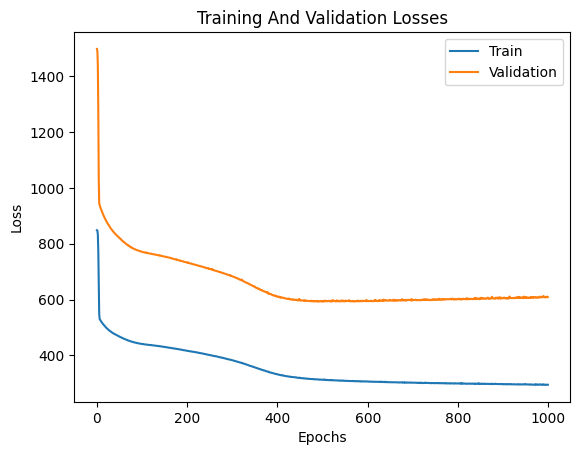

In [304]:
plt.plot(training_loss, label='Train')
plt.plot(validation_loss, label='Validation')
plt.legend()
plt.title("Training And Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [285]:
# model()

In [273]:
scaling_dict = {'maxval': maxval, 'minval': minval}
with open('models/scaling_dict.pkl', 'wb') as f:
    pickle.dump(scaling_dict, f)

### XGBoost

In [252]:
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

In [251]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final_data, y, test_size=0.25, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7338, 27), (2446, 27), (7338,), (2446,))

In [253]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_test, label=y_test)

In [259]:
params = {
    'objective': 'reg:squarederror',  # regression
    'eval_metric': 'rmse',            # root mean squared error
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

num_rounds = 1000

In [260]:
evals = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=10
)

[0]	train-rmse:47909.23253	val-rmse:48992.19165
[10]	train-rmse:29201.21437	val-rmse:30751.51701
[20]	train-rmse:23111.72793	val-rmse:25662.02933
[30]	train-rmse:20345.37976	val-rmse:23863.20359
[40]	train-rmse:19256.82213	val-rmse:23257.91279
[50]	train-rmse:18369.77487	val-rmse:22791.21719
[60]	train-rmse:17810.26785	val-rmse:22575.66491
[70]	train-rmse:17370.47834	val-rmse:22411.72336
[80]	train-rmse:16858.73573	val-rmse:22430.29033
[90]	train-rmse:16584.01145	val-rmse:22335.90038
[100]	train-rmse:16347.85819	val-rmse:22276.62408
[110]	train-rmse:16169.57364	val-rmse:22294.30818
[120]	train-rmse:15969.24906	val-rmse:22281.35640
[130]	train-rmse:15825.24613	val-rmse:22382.23379
[135]	train-rmse:15773.56810	val-rmse:22453.84868


In [263]:
y_pred = model.predict(dval)

# Compute RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 22479.6773


# Loading the model and making predictions for the poster
For this, I am going to used the trained MLP model on data for damen-lake to get predictions.}

In [28]:
def make_prediction(model, df, station_name, scaling_dict, device=torch.device('cuda')):
    '''
        This function takes data, scales it and makes predictions.
    '''
    # get data for the station name
    filtered = df[df['stationame'] == station_name]
    final_data = filtered.iloc[:, 4:].values
    final_data = np.hstack([filtered['age'].values.reshape(-1, 1), final_data])
    data = final_data.astype(np.float32)

    # scale the data
    maxval = scaling_dict['maxval']
    minval = scaling_dict['minval']
    data_scaled = (data-minval)/(maxval-minval)
    # converting it to tensor
    data_scaled_tensor = torch.tensor(data_scaled, device=device, dtype=torch.float32)

    # making prediction
    with torch.no_grad():
        preds = model(data_scaled_tensor)
    return preds.cpu().numpy().flatten()

In [29]:
# making loading the model
device = torch.device('cuda')
pred_model = Predictor(in_dim=27, out_dim=1).to(device)

In [30]:
pred_model.load_state_dict(torch.load('models/MLPv3.pt'))

<All keys matched successfully>

In [33]:
# loading the scaling dict
with open('models/scaling_dict.pkl', 'rb') as f:
    scaling_dict = pickle.load(f)

### Making predictions for the newly created stations:
#### 1. Damen-Lake

In [49]:
damen_lake_preds = make_prediction(model=pred_model, df=final_data_df, station_name = 'Damen-Lake', scaling_dict = scaling_dict)
inds = final_data_df[final_data_df['stationame']=='Damen-Lake'].index
damen_lake_true = y[inds]

In [86]:
dates = ridership_data[ridership_data['stationame']=='Damen-Lake']['month_beginning'].values
dates = np.array([datetime.strptime(d, r'%Y-%m-%d').date() for d in dates])
dates = np.array([ d.strftime("%b, %Y") for d in dates])
dates

array(['Aug, 2024', 'Sep, 2024', 'Oct, 2024', 'Nov, 2024', 'Dec, 2024',
       'Jan, 2025', 'Feb, 2025', 'Mar, 2025', 'Apr, 2025', 'May, 2025',
       'Jun, 2025', 'Jul, 2025', 'Aug, 2025', 'Sep, 2025'], dtype='<U9')

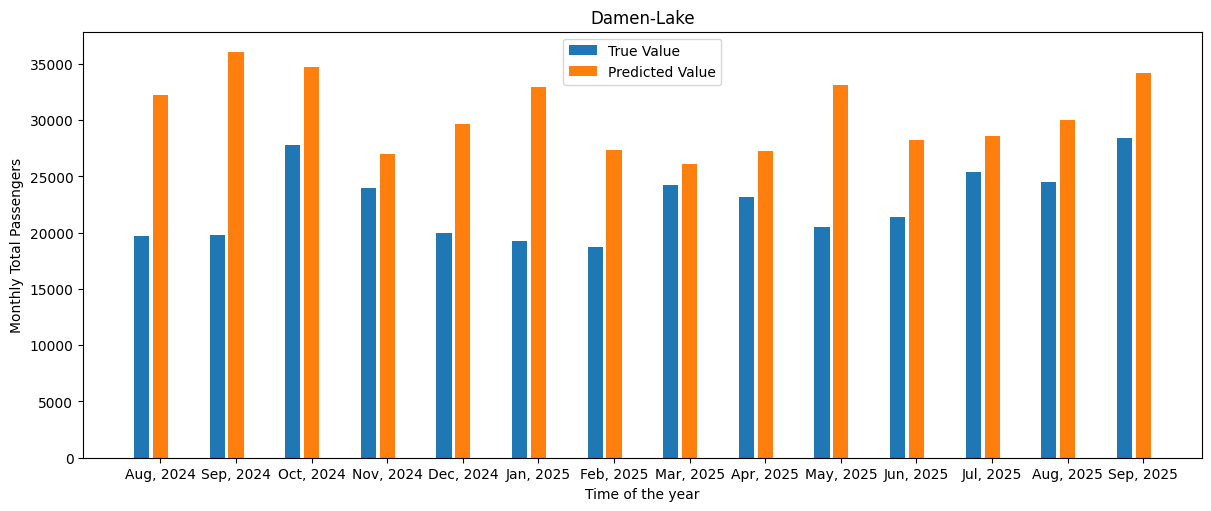

In [90]:
# plotting
import matplotlib.pyplot as plt


x = np.arange(len(dates))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,5), layout='constrained')
ax.bar(x, damen_lake_true, label='True Value', width=0.2)
ax.bar(x+width, damen_lake_preds, label='Predicted Value', width=0.2)
ax.set_xticks(x+width, dates)
ax.set_title("Damen-Lake")
ax.set_ylabel('Monthly Total Passengers')
ax.set_xlabel('Time of the year')
ax.legend()

plt.show()

#### 2. Berwyn

In [111]:
berwyn_preds = make_prediction(model=pred_model, df=final_data_df, station_name = 'Berwyn', scaling_dict = scaling_dict)
inds = final_data_df[final_data_df['stationame']=='Berwyn'].index
berwyn_true = y[inds]

In [112]:
dates = ridership_data[ridership_data['stationame']=='Berwyn']['month_beginning'].values
dates = np.array([datetime.strptime(d, r'%Y-%m-%d').date() for d in dates])
dates = np.array([ d.strftime("%b, %Y") for d in dates])
dates

array(['Jan, 2020', 'Feb, 2020', 'Mar, 2020', 'Apr, 2020', 'May, 2020',
       'Jun, 2020', 'Jul, 2020', 'Aug, 2020', 'Sep, 2020', 'Oct, 2020',
       'Nov, 2020', 'Dec, 2020', 'Jan, 2021', 'Feb, 2021', 'Mar, 2021',
       'Apr, 2021', 'May, 2021', 'Jul, 2025', 'Aug, 2025', 'Sep, 2025'],
      dtype='<U9')

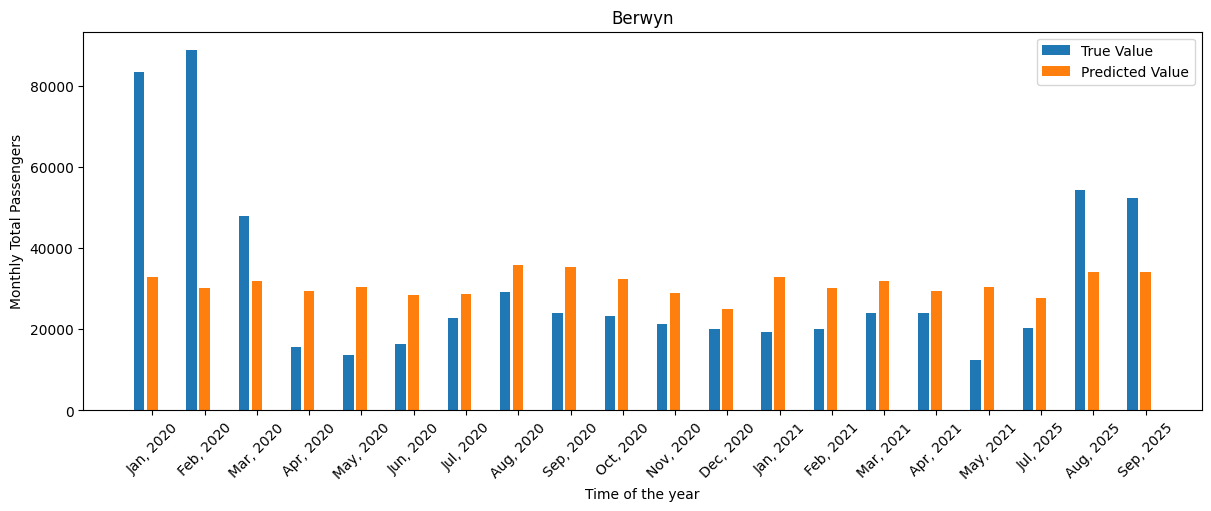

In [119]:
# plotting
import matplotlib.pyplot as plt


x = np.arange(len(dates))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,5), layout='constrained')
ax.bar(x, berwyn_true, label='True Value', width=0.2)
ax.bar(x+width, berwyn_preds, label='Predicted Value', width=0.2)
ax.set_xticks(x+width, dates)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title("Berwyn")
ax.set_ylabel('Monthly Total Passengers')
ax.set_xlabel('Time of the year')
ax.legend()

plt.show()

Lawrence

In [120]:
lawrence_preds = make_prediction(model=pred_model, df=final_data_df, station_name = 'Lawrence', scaling_dict = scaling_dict)
inds = final_data_df[final_data_df['stationame']=='Lawrence'].index
lawrence_true = y[inds]

In [121]:
dates = ridership_data[ridership_data['stationame']=='Lawrence']['month_beginning'].values
dates = np.array([datetime.strptime(d, r'%Y-%m-%d').date() for d in dates])
dates = np.array([ d.strftime("%b, %Y") for d in dates])
dates

array(['Jan, 2020', 'Feb, 2020', 'Mar, 2020', 'Apr, 2020', 'May, 2020',
       'Jun, 2020', 'Jul, 2020', 'Aug, 2020', 'Sep, 2020', 'Oct, 2020',
       'Nov, 2020', 'Dec, 2020', 'Jan, 2021', 'Feb, 2021', 'Mar, 2021',
       'Apr, 2021', 'May, 2021', 'Jul, 2025', 'Aug, 2025', 'Sep, 2025'],
      dtype='<U9')

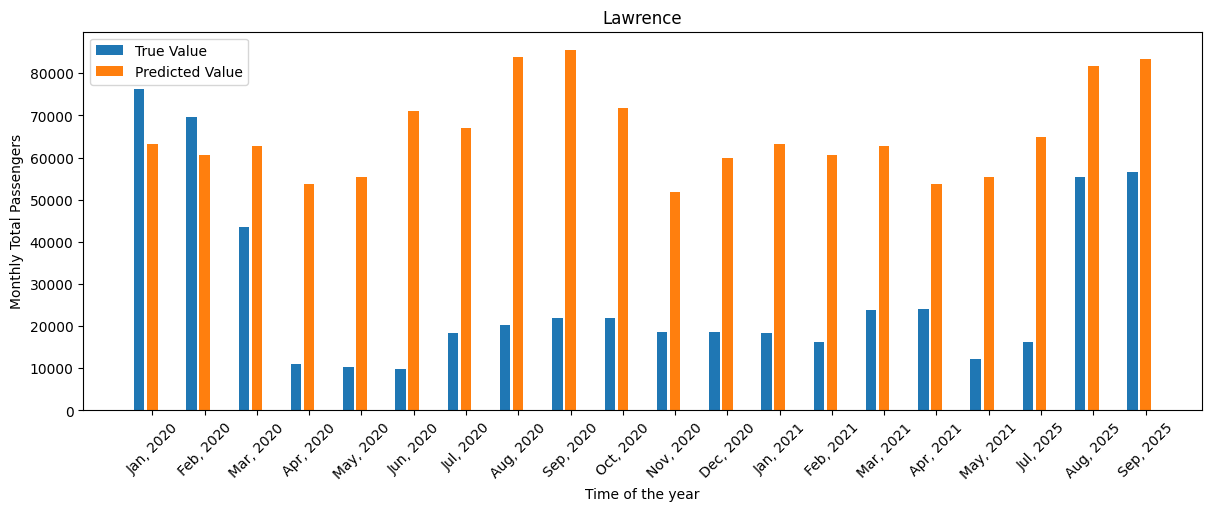

In [123]:
# plotting
import matplotlib.pyplot as plt


x = np.arange(len(dates))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,5), layout='constrained')
ax.bar(x, lawrence_true, label='True Value', width=0.2)
ax.bar(x+width, lawrence_preds, label='Predicted Value', width=0.2)
ax.set_xticks(x+width, dates)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title("Lawrence")
ax.set_ylabel('Monthly Total Passengers')
ax.set_xlabel('Time of the year')
ax.legend()

plt.show()

GPT

In [102]:
# Extract features exactly like training
filtered = final_data_df[final_data_df['stationame']=='Berwyn']
final_data = filtered.iloc[:, 4:].values
final_data = np.hstack([filtered['age'].values.reshape(-1, 1), final_data])

# Convert to float32
X = final_data.astype(np.float32)


In [103]:
minval = scaling_dict['minval']
maxval = scaling_dict['maxval']
X_scaled = (X - minval) / (maxval - minval)
# X_scaled = np.clip(X_scaled, 0, 1)  # avoids NaN if new data outside range

In [104]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=device)

In [105]:
with torch.no_grad():
    preds = pred_model(X_tensor)

# Convert to NumPy
preds = preds.cpu().numpy().flatten()


In [106]:
preds,

(array([32817.473, 30281.105, 31918.066, 29336.121, 30402.617, 28352.094,
        28816.09 , 35878.098, 35229.117, 32504.04 , 28994.516, 24946.47 ,
        32817.473, 30281.105, 31918.066, 29336.121, 30402.617, 27636.2  ,
        34058.727, 34060.27 ], dtype=float32),)

In [107]:
y[filtered.index]

array([83323., 88926., 47808., 15678., 13646., 16428., 22874., 29280.,
       23932., 23165., 21328., 20142., 19294., 20118., 24028., 23967.,
       12463., 20223., 54221., 52387.])

In [108]:
func_pred = make_prediction(pred_model, final_data_df, 'Berwyn', scaling_dict)
func_pred

array([32817.473, 30281.105, 31918.066, 29336.121, 30402.617, 28352.094,
       28816.09 , 35878.098, 35229.117, 32504.04 , 28994.516, 24946.47 ,
       32817.473, 30281.105, 31918.066, 29336.121, 30402.617, 27636.2  ,
       34058.727, 34060.27 ], dtype=float32)

In [38]:
damen_lake_preds

array([32278.45 , 36060.438, 34739.81 , 26996.232, 29637.117, 32944.723,
       27320.94 , 26119.312, 27239.156, 33087.805, 28279.3  , 28564.957,
       30007.852, 34207.27 ], dtype=float32)